## 한글폰트 적용

- 런타임 재시작

## 전이학습
- AlexNet, ResNet
- 좋은 모델들은 딥러닝 프레임워크를 통해서 이미 함수화를 제공.
- 사용자 입장 : 해당 중요 알고리즘들을 갖다 쓰면 됨.
- 가져와서 (살짝) 변형해서 현장에 맞게 적용해라.
- 특정한 알고리즘을 개발 시, 활용했던 이미지 데이터셋과 현장 데이터는 다름
- 현장에 맞도록 수정 보완해서 사용
- 키워드 : 파인 튜닝(Fine Tunning)
- 주요 알고리즘 : ResNet50 (이것만 기억할 것)

## 주요 라이브러리 호출

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalMaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## ResNet
- 2015년, MS에서 개발, 
- 논문 / 피인용 수, 
- 2015년 이전, 레이어를 어떻게 계속 그려나갈까?
  + 레이어를 늘리면 늘릴수록 성능이 올라감 / 문제는 연산량이 증가해서 개발속도가 떨어짐
  + 이것을 해결하기 위한 것이 잔차학습(Residual Learning) --> 지름길을 이용하면 속도가 빨라짐.  


In [2]:
# 사전에 훈련된 모델 내려받기
model = ResNet50(include_top=True,   # 기존 모델 사용 할 것인가?
                 weights='imagenet',  # imageNet에 사용된 가중치를 
                 input_tensor=None,
                 input_shape=None,
                 pooling=None,
                 classes=1000)

model.summary()

102967424/102967424 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                        

- 사전 훈련된 합성곱층의 가중치를 고정
- 밀집층 레이어를 추가 
- Fine Tunning의 영역

In [3]:
# 교재170p
model.trainable=False

# 성능을 올리려면?
# 머신러닝, Feature 추출, Feature를 좀 더 확인(통계/도메인 지식)
# 딥러닝, 모델을 바꾸거나, Fine Tunning=각 사용자가 레이어를 추가
model=Sequential([model, Dense(2, activation='sigmoid')])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1000)              25636712  
                                                                 
 dense (Dense)               (None, 2)                 2002      
                                                                 
Total params: 25,638,714
Trainable params: 2,002
Non-trainable params: 25,636,712
_________________________________________________________________


- 모델을 컴파일한다.

In [4]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

## ImageDataGenerator 클래스
- https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
- 이미지 데이터를 생성한다. 
  + (쓸만한)주어진 데이터의 크기는 현장에서는 매우 적다.
  + 가상으로 시뮬레이션을 하면서 데이터를 무작위로 생성할 필요가 있다.
- 더 많은 데이터 생성됐다.
  + 장점 : 정확도 상승 > 기존데이터,
  과대적합 방지
  + 단점 : 많아진 데이터 만큼 모델 개발 속도는 저하, 시간이 오래걸림

## 구글 드라이브 연동

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
BATCH_SIZE = 32
image_height=224
image_width=224

#경로
DATA_PATH='/content/drive/MyDrive/Colab Notebooks/산대특/deeplearning/ch02/data/catanddog'
train_dir = DATA_PATH + '/train'
valid_dir = DATA_PATH + '/validation'

print(train_dir)
print('/content/drive/MyDrive/Colab Notebooks/산대특/deeplearning/ch02/data/catanddog/train')

/content/drive/MyDrive/Colab Notebooks/산대특/deeplearning/ch02/data/catanddog/train
/content/drive/MyDrive/Colab Notebooks/산대특/deeplearning/ch02/data/catanddog/train


In [7]:
train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1
)

train_generator = train.flow_from_directory(train_dir,
                                            target_size=(image_height,image_width),
                                            color_mode='rgb',
                                            batch_size=BATCH_SIZE,
                                            seed=1,
                                            shuffle=True,
                                            class_mode='categorical')
valid = ImageDataGenerator(rescale=1.0/255.0)
valid_generator = train.flow_from_directory(valid_dir,
                                            target_size=(image_height,image_width),
                                            color_mode='rgb',
                                            batch_size=BATCH_SIZE,
                                            seed=1,
                                            shuffle=True,
                                            class_mode='categorical')
history = model.fit(train_generator,
                    epochs=10,
                    validation_data=valid_generator,
                    verbose=2)


Found 385 images belonging to 2 classes.
Found 98 images belonging to 2 classes.
Epoch 1/10
13/13 - 102s - loss: 0.6932 - accuracy: 0.4987 - val_loss: 0.6931 - val_accuracy: 0.5000 - 102s/epoch - 8s/step
Epoch 2/10
13/13 - 7s - loss: 0.6931 - accuracy: 0.5273 - val_loss: 0.6931 - val_accuracy: 0.5000 - 7s/epoch - 543ms/step
Epoch 3/10
13/13 - 7s - loss: 0.6931 - accuracy: 0.5299 - val_loss: 0.6931 - val_accuracy: 0.5000 - 7s/epoch - 546ms/step
Epoch 4/10
13/13 - 7s - loss: 0.6931 - accuracy: 0.5506 - val_loss: 0.6931 - val_accuracy: 0.5000 - 7s/epoch - 542ms/step
Epoch 5/10
13/13 - 7s - loss: 0.6931 - accuracy: 0.4675 - val_loss: 0.6931 - val_accuracy: 0.5000 - 7s/epoch - 545ms/step
Epoch 6/10
13/13 - 7s - loss: 0.6929 - accuracy: 0.5273 - val_loss: 0.6931 - val_accuracy: 0.5000 - 7s/epoch - 548ms/step
Epoch 7/10
13/13 - 7s - loss: 0.6928 - accuracy: 0.5273 - val_loss: 0.6931 - val_accuracy: 0.5000 - 7s/epoch - 547ms/step
Epoch 8/10
13/13 - 7s - loss: 0.6927 - accuracy: 0.5273 - val_lo

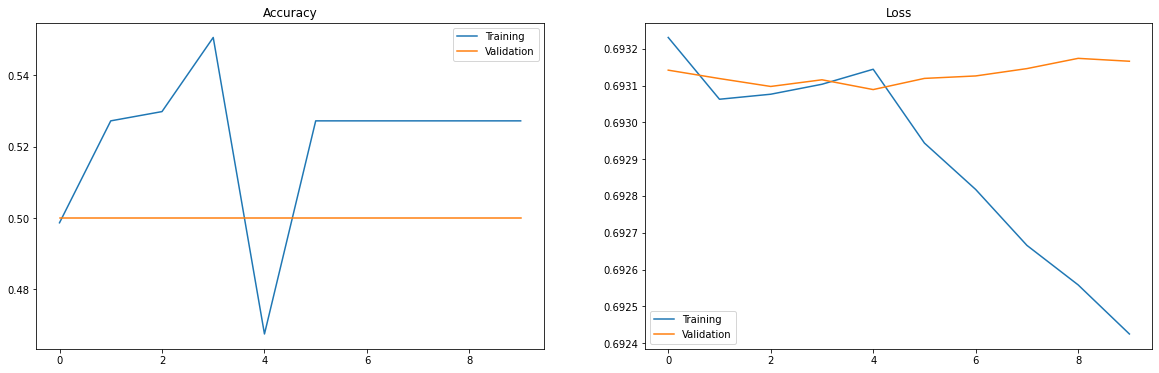

In [15]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs=range(len(accuracy))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
ax[0].plot(epochs, accuracy, label='Training')
ax[0].plot(epochs, val_accuracy, label='Validation')
ax[0].legend()
ax[0].set_title('Accuracy')

ax[1].plot(epochs, loss, label='Training')
ax[1].plot(epochs, val_loss, label='Validation')
ax[1].legend()
ax[1].set_title('Loss')


plt.show()
#전형적인 학습이 제대로 안 되고 있는 형태

## 훈련된 모델의 예측

1/1 [==============================] - 1s 1s/step


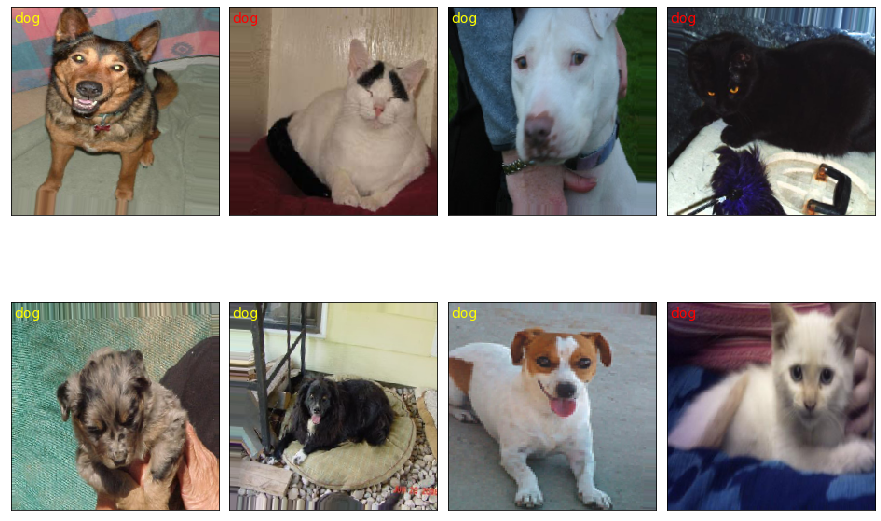

In [16]:
class_names = ['cat', 'dog']
validation, label_batch  = next(iter(valid_generator))
prediction_values = model.predict(validation)
prediction_values = np.argmax(prediction_values, axis=1)

fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(validation[i,:],cmap=plt.cm.gray_r, interpolation='nearest')
    if prediction_values[i] == np.argmax(label_batch[i]):
        ax.text(3, 17, class_names[prediction_values[i]], color='yellow', fontsize=14)
    else:
        ax.text(3, 17, class_names[prediction_values[i]], color='red', fontsize=14)
        

## 텐서플로 허브 사용
- https://tfhub.dev/google/imagenet/resnet_v2_152/feature_vector/5


In [18]:
import tensorflow_hub as hub

model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v2_152/feature_vector/4",
                   input_shape=(224, 224, 3),
                   trainable=False),  
    tf.keras.layers.Dense(2, activation='softmax')
])

In [19]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [20]:
train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1
)

train_generator = train.flow_from_directory(train_dir,
                                            target_size=(image_height,image_width),
                                            color_mode='rgb',
                                            batch_size=BATCH_SIZE,
                                            seed=1,
                                            shuffle=True,
                                            class_mode='categorical')
valid = ImageDataGenerator(rescale=1.0/255.0)
valid_generator = train.flow_from_directory(valid_dir,
                                            target_size=(image_height,image_width),
                                            color_mode='rgb',
                                            batch_size=BATCH_SIZE,
                                            seed=1,
                                            shuffle=True,
                                            class_mode='categorical')
history = model.fit(train_generator,
                    epochs=10,
                    validation_data=valid_generator,
                    verbose=2)

Found 385 images belonging to 2 classes.
Found 98 images belonging to 2 classes.
Epoch 1/10
13/13 - 20s - loss: 0.5229 - accuracy: 0.7558 - val_loss: 0.2204 - val_accuracy: 0.9490 - 20s/epoch - 2s/step
Epoch 2/10
13/13 - 8s - loss: 0.1284 - accuracy: 0.9740 - val_loss: 0.1163 - val_accuracy: 0.9694 - 8s/epoch - 602ms/step
Epoch 3/10
13/13 - 8s - loss: 0.0706 - accuracy: 0.9844 - val_loss: 0.1064 - val_accuracy: 0.9694 - 8s/epoch - 617ms/step
Epoch 4/10
13/13 - 8s - loss: 0.0575 - accuracy: 0.9896 - val_loss: 0.1127 - val_accuracy: 0.9490 - 8s/epoch - 624ms/step
Epoch 5/10
13/13 - 8s - loss: 0.0443 - accuracy: 0.9922 - val_loss: 0.1141 - val_accuracy: 0.9592 - 8s/epoch - 630ms/step
Epoch 6/10
13/13 - 8s - loss: 0.0370 - accuracy: 0.9974 - val_loss: 0.0893 - val_accuracy: 0.9796 - 8s/epoch - 615ms/step
Epoch 7/10
13/13 - 8s - loss: 0.0349 - accuracy: 0.9948 - val_loss: 0.0637 - val_accuracy: 0.9694 - 8s/epoch - 605ms/step
Epoch 8/10
13/13 - 8s - loss: 0.0361 - accuracy: 0.9922 - val_loss

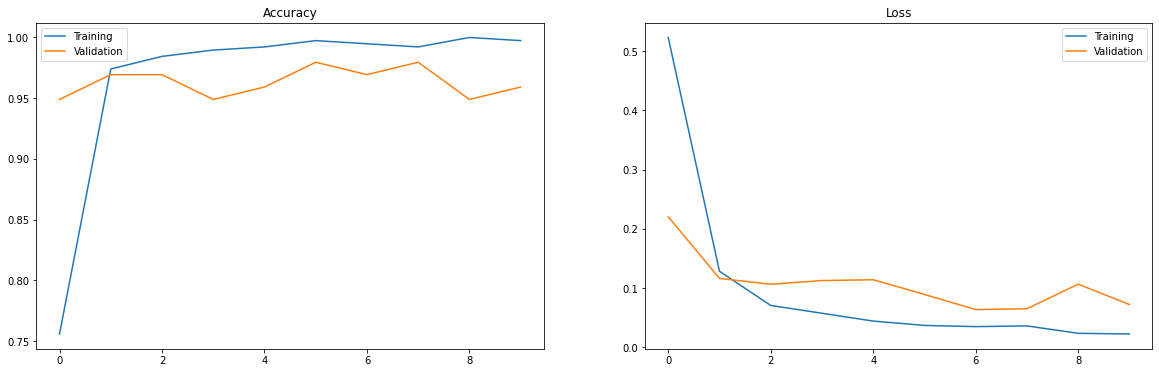

In [21]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs=range(len(accuracy))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
ax[0].plot(epochs, accuracy, label='Training')
ax[0].plot(epochs, val_accuracy, label='Validation')
ax[0].legend()
ax[0].set_title('Accuracy')

ax[1].plot(epochs, loss, label='Training')
ax[1].plot(epochs, val_loss, label='Validation')
ax[1].legend()
ax[1].set_title('Loss')


plt.show()

1/1 [==============================] - 1s 1s/step


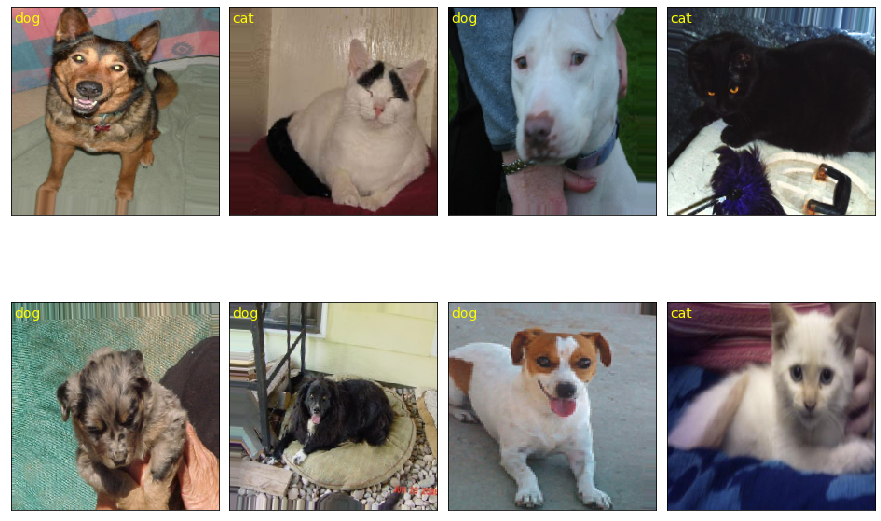

In [22]:
class_names = ['cat', 'dog']
validation, label_batch  = next(iter(valid_generator))
prediction_values = model.predict(validation)
prediction_values = np.argmax(prediction_values, axis=1)

fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(validation[i,:],cmap=plt.cm.gray_r, interpolation='nearest')
    if prediction_values[i] == np.argmax(label_batch[i]):
        ax.text(3, 17, class_names[prediction_values[i]], color='yellow', fontsize=14)
    else:
        ax.text(3, 17, class_names[prediction_values[i]], color='red', fontsize=14)